## DS 5110
## Final Project
### Anahita Sharma (ahs3zq), Anna Landi (aol4h), Zach Jacokes (zj6nw)

In [1]:
import numpy as np
import pandas as pd
import re
import os
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Data Import & Pre-Processing

In [4]:
pd.read_csv("/project/ds5559/group2_triage/ds5110_final_project/data_dictionary.csv", header = None, names = ["feature", "description"])

,feature,description
0,Group,1: Local ED / 2: Regional ED
1,Sex,1: Female / 2: Male
2,Age,Age (Years)
3,Patients number per hour,Patients number/hous
4,Arrival mode,1: Walking / 2: 119 use / 3: Private car / 4: ...
5,Injury,1: Non-injury / 2: Injury
6,Mental,1: Alert / 2: Verval response / 3: Pain respon...
7,Pain,1: Pain / 2: Non-pain
8,NRS_pain,Numeric rating scales of pain
9,SBP,Systolid blood pressure


In [5]:
encounters = sc.textFile("/project/ds5559/group2_triage/ds5110_final_project/triage_data.csv")
encounters.take(5)

['Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage',
 '2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,Corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"Burn of hand, firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, Lt",1,1,2,130,80,102,20,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1']

In [6]:
spark.read.csv("/project/ds5559/group2_triage/ds5110_final_project/triage_data.csv", header = True).show(10)

+-----+---+---+------------------------+------------+------+--------------------+------+----+--------+---+---+---+---+----+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|Group|Sex|Age|Patients number per hour|Arrival mode|Injury|      Chief_complain|Mental|Pain|NRS_pain|SBP|DBP| HR| RR|  BT|Saturation|KTAS_RN|     Diagnosis in ED|Disposition|KTAS_expert|Error_group|Length of stay_min|KTAS duration_min|mistriage|
+-----+---+---+------------------------+------------+------+--------------------+------+----+--------+---+---+---+---+----+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|    2|  2| 71|                       3|           3|     2|   right ocular pain|     1|   1|       2|160|100| 84| 18|36.6|       100|      2|    Corneal abrasion|          1|          4|          2|                86|             5.00|        1|
|    1|  1| 

In [7]:
header = encounters.first()
encounters_no_header = encounters.filter(lambda x: header != x)

In [8]:
header

'Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage'

In [9]:
encounters_no_header.take(5)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,Corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"Burn of hand, firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, Lt",1,1,2,130,80,102,20,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1',
 '1,2,58,4,3,1,"distension, abd",1,1,3,91,67,93,18,36.5,,4,Ascites,1,5,8,109,6.60,1']

In [10]:
index_cc = header.split(",").index("Chief_complain")
index_cc

6

In [11]:
encounters_lower = encounters_no_header.map(lambda x: x.lower())
encounters_lower.take(5)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"burn of hand, firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, lt",1,1,2,130,80,102,20,36.6,98,4,"fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1',
 '1,2,58,4,3,1,"distension, abd",1,1,3,91,67,93,18,36.5,,4,ascites,1,5,8,109,6.60,1']

In [12]:
encounters_lower.take(28)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"burn of hand, firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, lt",1,1,2,130,80,102,20,36.6,98,4,"fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1',
 '1,2,58,4,3,1,"distension, abd",1,1,3,91,67,93,18,36.5,,4,ascites,1,5,8,109,6.60,1',
 '2,1,54,6,4,1,fever,1,1,3,140,90,94,20,38.1,98,3,"fever, unspecified",2,4,1,9246,2.00,1',
 '2,2,49,11,3,1,with chest discomfort,1,1,3,110,70,70,20,36.2,98,2,"angina pectoris, unspecified",1,3,2,400,3.00,1',
 '1,2,78,14,3,1,"pain, chest",1,1,3,169,86,80,20,36,,2,acute coronary syndrome,1,3,2,247,10.23,1',
 '1,2,32,10,3,1,lbp - low back pain,1,1,3,140,75,91,20,36.6,,4,herniated disc disease of lumbar spine with radiculopathy,1,5,4,59,3.23,1',
 '2,1,38,6,

In [13]:
encounters_comma = encounters_lower.map(lambda row: re.sub('(".*)(,\s*)(.*")', r'\1;\3', row))
encounters_comma.take(28)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,36.6,100,2,corneal abrasion,1,4,2,86,5.00,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,36.5,,4,"burn of hand;firts degree dorsum",1,5,4,64,3.95,1',
 '2,1,68,8,2,2,"arm pain, lt",1,1,2,130,80,102,20,36.6,98,4,"fracture of surgical neck of humerus;closed",2,5,4,862,1.00,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,36.5,,4,alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1',
 '1,2,58,4,3,1,"distension;abd",1,1,3,91,67,93,18,36.5,,4,ascites,1,5,8,109,6.60,1',
 '2,1,54,6,4,1,fever,1,1,3,140,90,94,20,38.1,98,3,"fever;unspecified",2,4,1,9246,2.00,1',
 '2,2,49,11,3,1,with chest discomfort,1,1,3,110,70,70,20,36.2,98,2,"angina pectoris;unspecified",1,3,2,400,3.00,1',
 '1,2,78,14,3,1,"pain;chest",1,1,3,169,86,80,20,36,,2,acute coronary syndrome,1,3,2,247,10.23,1',
 '1,2,32,10,3,1,lbp - low back pain,1,1,3,140,75,91,20,36.6,,4,herniated disc disease of lumbar spine with radiculopathy,1,5,4,59,3.23,1',
 '2,1,38,6,3,1,"e

In [14]:
encounters_english = encounters_comma.map(lambda row: re.sub("[^a-zA-Z0-9,;\s]", "", row))
encounters_english.take(25)

['2,2,71,3,3,2,right ocular pain,1,1,2,160,100,84,18,366,100,2,corneal abrasion,1,4,2,86,500,1',
 '1,1,56,12,3,2,right forearm burn,1,1,2,137,75,60,20,365,,4,burn of hand;firts degree dorsum,1,5,4,64,395,1',
 '2,1,68,8,2,2,arm pain, lt,1,1,2,130,80,102,20,366,98,4,fracture of surgical neck of humerus;closed,2,5,4,862,100,1',
 '1,2,71,8,1,1,ascites tapping,1,1,3,139,94,88,20,365,,4,alcoholic liver cirrhosis with ascites,1,5,6,108,983,1',
 '1,2,58,4,3,1,distension;abd,1,1,3,91,67,93,18,365,,4,ascites,1,5,8,109,660,1',
 '2,1,54,6,4,1,fever,1,1,3,140,90,94,20,381,98,3,fever;unspecified,2,4,1,9246,200,1',
 '2,2,49,11,3,1,with chest discomfort,1,1,3,110,70,70,20,362,98,2,angina pectoris;unspecified,1,3,2,400,300,1',
 '1,2,78,14,3,1,pain;chest,1,1,3,169,86,80,20,36,,2,acute coronary syndrome,1,3,2,247,1023,1',
 '1,2,32,10,3,1,lbp  low back pain,1,1,3,140,75,91,20,366,,4,herniated disc disease of lumbar spine with radiculopathy,1,5,4,59,323,1',
 '2,1,38,6,3,1,eczema;eyelid,1,1,3,130,80,80,20,3

In [15]:
len(encounters_english.first().split(","))

24

In [16]:
encounters_split = encounters_english.map(lambda x: re.sub("  ", "-", x)) \
                                     .map(lambda x: re.sub(", ,", ",,", x)) \
                                     .map(lambda x: re.sub(", ", ";", x)) \
                                     .map(lambda x: x.rstrip()) \
                                     .map(lambda x: x.split(","))
encounters_split.take(2)

[['2',
  '2',
  '71',
  '3',
  '3',
  '2',
  'right ocular pain',
  '1',
  '1',
  '2',
  '160',
  '100',
  '84',
  '18',
  '366',
  '100',
  '2',
  'corneal abrasion',
  '1',
  '4',
  '2',
  '86',
  '500',
  '1'],
 ['1',
  '1',
  '56',
  '12',
  '3',
  '2',
  'right forearm burn',
  '1',
  '1',
  '2',
  '137',
  '75',
  '60',
  '20',
  '365',
  '',
  '4',
  'burn of hand;firts degree dorsum',
  '1',
  '5',
  '4',
  '64',
  '395',
  '1']]

In [17]:
encounters_comma.take(66)[65]

'1,1,70,10,3,1,목이 아픔,1,1,3,176,103,73,16,36.8,,5,hyperventilation,1,4,4,161,4.97,2'

In [18]:
encounters_english.take(66)[65]

'1,1,70,10,3,1, ,1,1,3,176,103,73,16,368,,5,hyperventilation,1,4,4,161,497,2'

In [19]:
encounters_split.take(66)[65]

['1',
 '1',
 '70',
 '10',
 '3',
 '1',
 '',
 '1',
 '1',
 '3',
 '176',
 '103',
 '73',
 '16',
 '368',
 '',
 '5',
 'hyperventilation',
 '1',
 '4',
 '4',
 '161',
 '497',
 '2']

In [20]:
len(encounters_split.take(66)[65])

24

In [21]:
df = encounters_split.toDF(header.split(","))
df.show(5, truncate = False)

+-----+---+---+------------------------+------------+------+------------------+------+----+--------+---+---+---+---+---+----------+-------+-------------------------------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|Group|Sex|Age|Patients number per hour|Arrival mode|Injury|Chief_complain    |Mental|Pain|NRS_pain|SBP|DBP|HR |RR |BT |Saturation|KTAS_RN|Diagnosis in ED                            |Disposition|KTAS_expert|Error_group|Length of stay_min|KTAS duration_min|mistriage|
+-----+---+---+------------------------+------------+------+------------------+------+----+--------+---+---+---+---+---+----------+-------+-------------------------------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|2    |2  |71 |3                       |3           |2     |right ocular pain |1     |1   |2       |160|100|84 |18 |366|100       |2      |corneal abrasion                           |1          |4   

## Exploratory Data Analysis

In [22]:
# Number of rows in the dataset
num_rows = df.count()
num_rows

1267

In [23]:
# Number of columns in the dataset
len(df.columns)

24

In [24]:
# Response variable summary
mistriage_df = df.groupby("mistriage").count()
mistriage_df = mistriage_df.withColumn("percentage", mistriage_df["count"] / num_rows)
mistriage_df.show()

+---------+-----+--------------------+
|mistriage|count|          percentage|
+---------+-----+--------------------+
|        0| 1081|  0.8531965272296764|
|        1|   55|0.043409629044988164|
|        2|  131| 0.10339384372533544|
+---------+-----+--------------------+



In [25]:
# Potential predictor variables
cat_features = ["Group", "Sex", "Arrival mode", "Injury", "Mental", "Pain", "Disposition"]
num_features = ["Age", "Patients number per hour", "NRS_pain", "SBP", "DBP", "HR", "RR", "BT", "Saturation", "KTAS_RN", "Length of stay_min", "KTAS duration_min"]

In [26]:
cat_df = df.select(cat_features)
cat_df.show(5)

+-----+---+------------+------+------+----+-----------+
|Group|Sex|Arrival mode|Injury|Mental|Pain|Disposition|
+-----+---+------------+------+------+----+-----------+
|    2|  2|           3|     2|     1|   1|          1|
|    1|  1|           3|     2|     1|   1|          1|
|    2|  1|           2|     2|     1|   1|          2|
|    1|  2|           1|     1|     1|   1|          1|
|    1|  2|           3|     1|     1|   1|          1|
+-----+---+------------+------+------+----+-----------+
only showing top 5 rows



In [27]:
group_df = df.groupby("Group").count()
group_df = group_df.withColumn("percentage", group_df["count"] / num_rows)
group_df.show()

+-----+-----+------------------+
|Group|count|        percentage|
+-----+-----+------------------+
|    1|  688|0.5430149960536701|
|    2|  579|0.4569850039463299|
+-----+-----+------------------+



In [28]:
for i in cat_df.columns:
    tmp = cat_df.groupby(i).count()
    #num_rows = tmp.count()
    tmp = tmp.withColumn("percentage", (tmp["count"] / num_rows)*100)
    tmp.show()

+-----+-----+-----------------+
|Group|count|       percentage|
+-----+-----+-----------------+
|    1|  688|54.30149960536701|
|    2|  579|45.69850039463299|
+-----+-----+-----------------+

+---+-----+------------------+
|Sex|count|        percentage|
+---+-----+------------------+
|  1|  606|47.829518547750595|
|  2|  661|52.170481452249405|
+---+-----+------------------+

+------------+-----+-------------------+
|Arrival mode|count|         percentage|
+------------+-----+-------------------+
|           7|    2|0.15785319652722968|
|           3|  753| 59.431728492501975|
|           5|    2|0.15785319652722968|
|           6|   10| 0.7892659826361484|
|           1|   79|  6.235201262825572|
|           4|  155| 12.233622730860299|
|           2|  266| 20.994475138121548|
+------------+-----+-------------------+

+------+-----+------------------+
|Injury|count|        percentage|
+------+-----+------------------+
|     1| 1023| 80.74191002367797|
|     2|  244|19.258089976322022

In [29]:
num_df = df.select(num_features)
num_df.show(5)

+---+------------------------+--------+---+---+---+---+---+----------+-------+------------------+-----------------+
|Age|Patients number per hour|NRS_pain|SBP|DBP| HR| RR| BT|Saturation|KTAS_RN|Length of stay_min|KTAS duration_min|
+---+------------------------+--------+---+---+---+---+---+----------+-------+------------------+-----------------+
| 71|                       3|       2|160|100| 84| 18|366|       100|      2|                86|              500|
| 56|                      12|       2|137| 75| 60| 20|365|          |      4|                64|              395|
| 68|                       8|       2|130| 80|102| 20|366|        98|      4|               862|              100|
| 71|                       8|       3|139| 94| 88| 20|365|          |      4|               108|              983|
| 58|                       4|       3| 91| 67| 93| 18|365|          |      4|               109|              660|
+---+------------------------+--------+---+---+---+---+---+----------+--

In [30]:
num_df.summary().show(truncate = 15)

+-------+---------------+------------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+------------------+-----------------+
|summary|            Age|Patients number per hour|       NRS_pain|            SBP|            DBP|             HR|             RR|             BT|     Saturation|        KTAS_RN|Length of stay_min|KTAS duration_min|
+-------+---------------+------------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+------------------+-----------------+
|  count|           1267|                    1267|           1267|           1267|           1267|           1267|           1267|           1267|           1267|           1267|              1267|             1267|
|   mean|54.423835832...|         7.5193370165...|4.1040787623...|133.64895330...|79.780290791...|83.963111467...|19.506827309...|325.99

In [31]:
num_df.printSchema()
# Might explain why the max values for some of the features are 99, which is less than some of the other values --> need to change schema before further analysis

root
 |-- Age: string (nullable = true)
 |-- Patients number per hour: string (nullable = true)
 |-- NRS_pain: string (nullable = true)
 |-- SBP: string (nullable = true)
 |-- DBP: string (nullable = true)
 |-- HR: string (nullable = true)
 |-- RR: string (nullable = true)
 |-- BT: string (nullable = true)
 |-- Saturation: string (nullable = true)
 |-- KTAS_RN: string (nullable = true)
 |-- Length of stay_min: string (nullable = true)
 |-- KTAS duration_min: string (nullable = true)



## Model Building

In [33]:
df = df.withColumnRenamed("Patients number per hour", "Patients_number_per_hour") \
       .withColumnRenamed("Arrival mode", "Arrival_mode") \
       .withColumnRenamed("Diagnosis in ED", "Diagnosis_in_ed") \
       .withColumnRenamed("Length of stay_min", "Length_of_stay_min") \
       .withColumnRenamed("KTAS duration_min", "KTAS_duration_min")
df.show(10)

+-----+---+---+------------------------+------------+------+--------------------+------+----+--------+---+---+---+---+---+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|      Chief_complain|Mental|Pain|NRS_pain|SBP|DBP| HR| RR| BT|Saturation|KTAS_RN|     Diagnosis_in_ed|Disposition|KTAS_expert|Error_group|Length_of_stay_min|KTAS_duration_min|mistriage|
+-----+---+---+------------------------+------------+------+--------------------+------+----+--------+---+---+---+---+---+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|    2|  2| 71|                       3|           3|     2|   right ocular pain|     1|   1|       2|160|100| 84| 18|366|       100|      2|    corneal abrasion|          1|          4|          2|                86|              500|        1|
|    1|  1| 56| 

In [34]:
from pyspark.sql.types import IntegerType, BooleanType, DateType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

df_ints = df.withColumn("Age", df.Age.cast(IntegerType())) \
            .withColumn("Patients_number_per_hour", df.Patients_number_per_hour.cast(IntegerType())) \
            .withColumn("NRS_pain", df.NRS_pain.cast(IntegerType())) \
            .withColumn("SBP", df.SBP.cast(IntegerType())) \
            .withColumn("DBP", df.DBP.cast(IntegerType())) \
            .withColumn("HR", df.HR.cast(IntegerType())) \
            .withColumn("RR", df.RR.cast(IntegerType())) \
            .withColumn("BT", df.BT.cast(IntegerType())) \
            .withColumn("Saturation", df.Saturation.cast(IntegerType())) \
            .withColumn("KTAS_RN", df.KTAS_RN.cast(IntegerType())) \
            .withColumn("Length_of_stay_min", df.Length_of_stay_min.cast(IntegerType())) \
            .withColumn("KTAS_duration_min", df.KTAS_duration_min.cast(IntegerType())) \
            .withColumn("mistriage", df.mistriage.cast(IntegerType()))
            #.withColumn("Injury", df.Injury.cast(IntegerType())) \

In [35]:
df_ints.show(5)

+-----+---+---+------------------------+------------+------+------------------+------+----+--------+---+---+---+---+---+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|    Chief_complain|Mental|Pain|NRS_pain|SBP|DBP| HR| RR| BT|Saturation|KTAS_RN|     Diagnosis_in_ed|Disposition|KTAS_expert|Error_group|Length_of_stay_min|KTAS_duration_min|mistriage|
+-----+---+---+------------------------+------------+------+------------------+------+----+--------+---+---+---+---+---+----------+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|    2|  2| 71|                       3|           3|     2| right ocular pain|     1|   1|       2|160|100| 84| 18|366|       100|      2|    corneal abrasion|          1|          4|          2|                86|              500|        1|
|    1|  1| 56|         

In [36]:
# drop columns where more than half the rows are Null
from pyspark.sql.functions import isnan, when, count, col
df_ints.select([count(when(col(c).isNull(), c)).alias(c) for c in df_ints.columns]).show()

# based on these null counts, we should remove the NRS_pain & saturation columns

+-----+---+---+------------------------+------------+------+--------------+------+----+--------+---+---+---+---+---+----------+-------+---------------+-----------+-----------+-----------+------------------+-----------------+---------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|Chief_complain|Mental|Pain|NRS_pain|SBP|DBP| HR| RR| BT|Saturation|KTAS_RN|Diagnosis_in_ed|Disposition|KTAS_expert|Error_group|Length_of_stay_min|KTAS_duration_min|mistriage|
+-----+---+---+------------------------+------------+------+--------------+------+----+--------+---+---+---+---+---+----------+-------+---------------+-----------+-----------+-----------+------------------+-----------------+---------+
|    0|  0|  0|                       0|           0|     0|             0|     0|   0|     556| 25| 29| 20| 22| 18|       697|      0|              0|          0|          0|          0|                 0|                0|        0|
+-----+---+---+------------------------+------------+------+

In [37]:
df_dropped = df_ints.drop("NRS_pain", "Saturation")
df_dropped.show(5)

+-----+---+---+------------------------+------------+------+------------------+------+----+---+---+---+---+---+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|    Chief_complain|Mental|Pain|SBP|DBP| HR| RR| BT|KTAS_RN|     Diagnosis_in_ed|Disposition|KTAS_expert|Error_group|Length_of_stay_min|KTAS_duration_min|mistriage|
+-----+---+---+------------------------+------------+------+------------------+------+----+---+---+---+---+---+-------+--------------------+-----------+-----------+-----------+------------------+-----------------+---------+
|    2|  2| 71|                       3|           3|     2| right ocular pain|     1|   1|160|100| 84| 18|366|      2|    corneal abrasion|          1|          4|          2|                86|              500|        1|
|    1|  1| 56|                      12|           3|     2|right forearm burn|     1|   1|137| 75| 60| 

In [38]:
# replace null values with the mean of that respective column
from pyspark.ml.feature import Imputer
impute_cols = ["SBP", "DBP", "HR", "RR", "BT"]

imputer = Imputer(
    inputCols = impute_cols, 
    outputCols = ["{}_imputed".format(c) for c in impute_cols],
    strategy = "mean")
df_imputed = imputer.fit(df_dropped).transform(df_dropped).drop("SBP", "DBP", "HR", "RR", "BT")

df_imputed.select([count(when(col(c).isNull(), c)).alias(c) for c in df_imputed.columns]).show()

+-----+---+---+------------------------+------------+------+--------------+------+----+-------+---------------+-----------+-----------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|Chief_complain|Mental|Pain|KTAS_RN|Diagnosis_in_ed|Disposition|KTAS_expert|Error_group|Length_of_stay_min|KTAS_duration_min|mistriage|RR_imputed|SBP_imputed|DBP_imputed|HR_imputed|BT_imputed|
+-----+---+---+------------------------+------------+------+--------------+------+----+-------+---------------+-----------+-----------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+
|    0|  0|  0|                       0|           0|     0|             0|     0|   0|      0|              0|          0|          0|          0|                 0|                0|        0|         0|          0|          0|         0|    

In [39]:
df_imputed = df_imputed.drop("KTAS_expert", "Error_group")

In [40]:
df_imputed.columns

['Group',
 'Sex',
 'Age',
 'Patients_number_per_hour',
 'Arrival_mode',
 'Injury',
 'Chief_complain',
 'Mental',
 'Pain',
 'KTAS_RN',
 'Diagnosis_in_ed',
 'Disposition',
 'Length_of_stay_min',
 'KTAS_duration_min',
 'mistriage',
 'RR_imputed',
 'SBP_imputed',
 'DBP_imputed',
 'HR_imputed',
 'BT_imputed']

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df_imputed_pandas = df_imputed.toPandas()

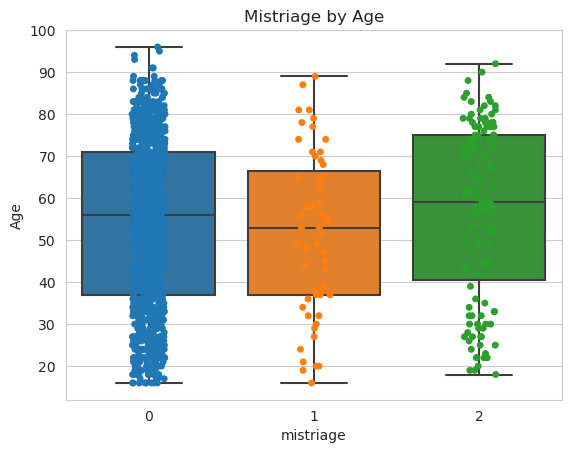

In [43]:
sns.set_style('whitegrid')
ax = sns.boxplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['Age'])
ax = sns.stripplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['Age'])
plt.title('Mistriage by Age')
plt.show()

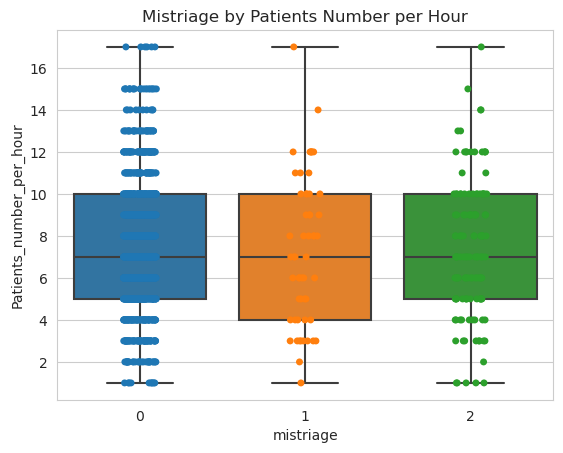

In [44]:
sns.set_style('whitegrid')
ax = sns.boxplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['Patients_number_per_hour'])
ax = sns.stripplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['Patients_number_per_hour'])
plt.title('Mistriage by Patients Number per Hour')
plt.show()

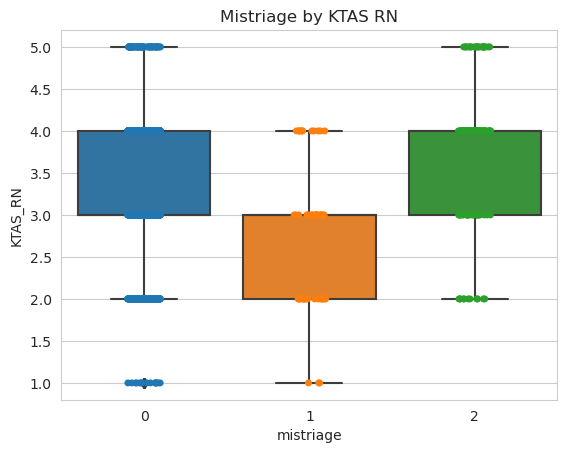

In [45]:
sns.set_style('whitegrid')
ax = sns.boxplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['KTAS_RN'])
ax = sns.stripplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['KTAS_RN'])
plt.title('Mistriage by KTAS RN')
plt.show()

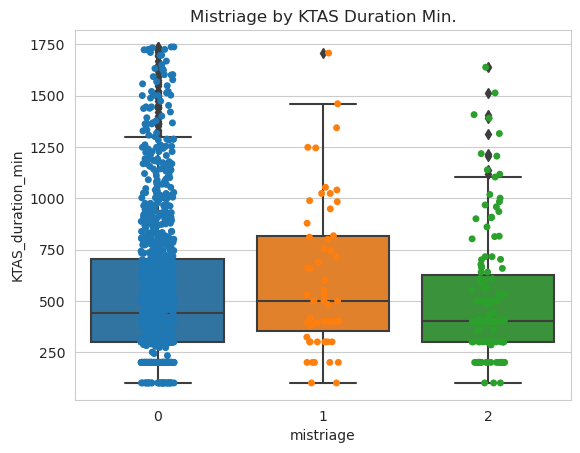

In [46]:
sns.set_style('whitegrid')
ax = sns.boxplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['KTAS_duration_min'])
ax = sns.stripplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['KTAS_duration_min'])
plt.title('Mistriage by KTAS Duration Min.')
plt.show()

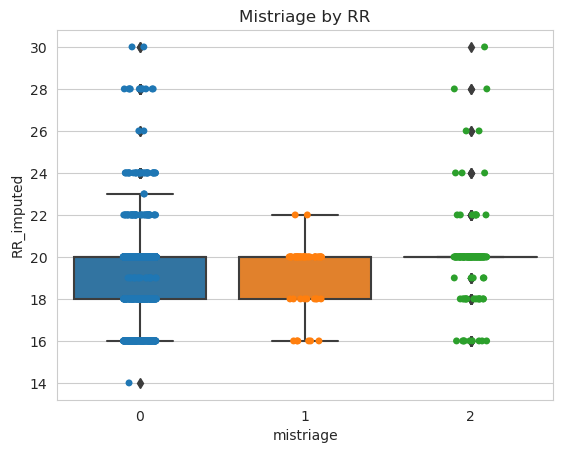

In [47]:
sns.set_style('whitegrid')
ax = sns.boxplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['RR_imputed'])
ax = sns.stripplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['RR_imputed'])
plt.title('Mistriage by RR')
plt.show()

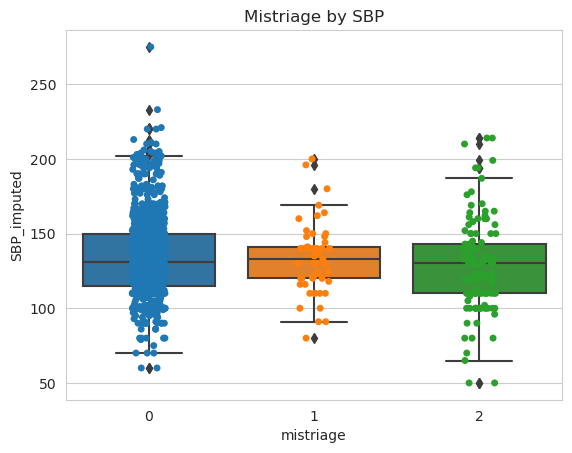

In [48]:
sns.set_style('whitegrid')
ax = sns.boxplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['SBP_imputed'])
ax = sns.stripplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['SBP_imputed'])
plt.title('Mistriage by SBP')
plt.show()

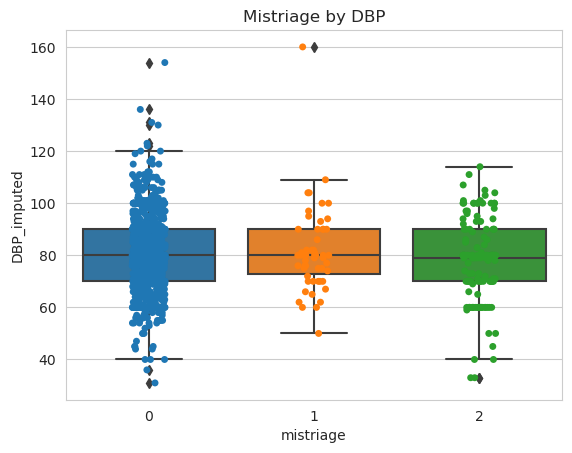

In [49]:
sns.set_style('whitegrid')
ax = sns.boxplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['DBP_imputed'])
ax = sns.stripplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['DBP_imputed'])
plt.title('Mistriage by DBP')
plt.show()

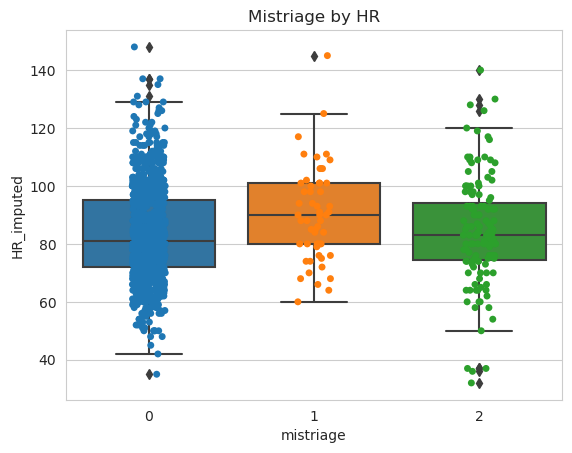

In [50]:
sns.set_style('whitegrid')
ax = sns.boxplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['HR_imputed'])
ax = sns.stripplot(x = df_imputed_pandas['mistriage'], y = df_imputed_pandas['HR_imputed'])
plt.title('Mistriage by HR')
plt.show()

In [52]:
from pyspark.sql.functions import concat_ws
df_combined = df_imputed.withColumn("CC_Diagnosis", concat_ws(" ", df.Chief_complain, df.Diagnosis_in_ed))
df_combined.select("CC_Diagnosis").show(15, truncate = False)

+---------------------------------------------------------------------------+
|CC_Diagnosis                                                               |
+---------------------------------------------------------------------------+
|right ocular pain corneal abrasion                                         |
|right forearm burn burn of hand;firts degree dorsum                        |
|arm pain;lt fracture of surgical neck of humerus;closed                    |
|ascites tapping alcoholic liver cirrhosis with ascites                     |
|distension;abd ascites                                                     |
|fever fever;unspecified                                                    |
|with chest discomfort angina pectoris;unspecified                          |
|pain;chest acute coronary syndrome                                         |
|lbp-low back pain herniated disc disease of lumbar spine with radiculopathy|
|eczema;eyelid ocular pain                                      

In [53]:
df_combined.show(5)

+-----+---+---+------------------------+------------+------+------------------+------+----+-------+--------------------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+--------------------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|    Chief_complain|Mental|Pain|KTAS_RN|     Diagnosis_in_ed|Disposition|Length_of_stay_min|KTAS_duration_min|mistriage|RR_imputed|SBP_imputed|DBP_imputed|HR_imputed|BT_imputed|        CC_Diagnosis|
+-----+---+---+------------------------+------------+------+------------------+------+----+-------+--------------------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+--------------------+
|    2|  2| 71|                       3|           3|     2| right ocular pain|     1|   1|      2|    corneal abrasion|          1|                86|              500|        1|        18|        160|        100|        84| 

In [54]:
from pyspark.sql.functions import regexp_replace, trim
df_combined = df_combined.withColumn("CC_Diagnosis", trim(regexp_replace("CC_Diagnosis", ";|-", " ")))
df_combined.select("CC_Diagnosis").show(25, truncate = False)

+---------------------------------------------------------------------------+
|CC_Diagnosis                                                               |
+---------------------------------------------------------------------------+
|right ocular pain corneal abrasion                                         |
|right forearm burn burn of hand firts degree dorsum                        |
|arm pain lt fracture of surgical neck of humerus closed                    |
|ascites tapping alcoholic liver cirrhosis with ascites                     |
|distension abd ascites                                                     |
|fever fever unspecified                                                    |
|with chest discomfort angina pectoris unspecified                          |
|pain chest acute coronary syndrome                                         |
|lbp low back pain herniated disc disease of lumbar spine with radiculopathy|
|eczema eyelid ocular pain                                      

In [55]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol = "CC_Diagnosis", outputCol = "words")
cc_diagnosis_features = tokenizer.transform(df_combined)
cc_diagnosis_features.select("words").show(15, truncate = False)

+----------------------------------------------------------------------------------------+
|words                                                                                   |
+----------------------------------------------------------------------------------------+
|[right, ocular, pain, corneal, abrasion]                                                |
|[right, forearm, burn, burn, of, hand, firts, degree, dorsum]                           |
|[arm, pain, lt, fracture, of, surgical, neck, of, humerus, closed]                      |
|[ascites, tapping, alcoholic, liver, cirrhosis, with, ascites]                          |
|[distension, abd, ascites]                                                              |
|[fever, fever, unspecified]                                                             |
|[with, chest, discomfort, angina, pectoris, unspecified]                                |
|[pain, chest, acute, coronary, syndrome]                                                |

In [56]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol = "words", outputCol = "filtered")
removedData = remover.transform(cc_diagnosis_features)
removedData.select("filtered").show(15, truncate = False)

+------------------------------------------------------------------------------+
|filtered                                                                      |
+------------------------------------------------------------------------------+
|[right, ocular, pain, corneal, abrasion]                                      |
|[right, forearm, burn, burn, hand, firts, degree, dorsum]                     |
|[arm, pain, lt, fracture, surgical, neck, humerus, closed]                    |
|[ascites, tapping, alcoholic, liver, cirrhosis, ascites]                      |
|[distension, abd, ascites]                                                    |
|[fever, fever, unspecified]                                                   |
|[chest, discomfort, angina, pectoris, unspecified]                            |
|[pain, chest, acute, coronary, syndrome]                                      |
|[lbp, low, back, pain, herniated, disc, disease, lumbar, spine, radiculopathy]|
|[eczema, eyelid, ocular, pa

## Data Splitting

In [57]:
trainingData, testData = removedData.randomSplit([0.8, 0.2], seed = 123)
trainingData.show(5, truncate = False)

+-----+---+---+------------------------+------------+------+------------------------+------+----+-------+------------------------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+----------------------------------------------+-----------------------------------------------------+-------------------------------------------------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|Chief_complain          |Mental|Pain|KTAS_RN|Diagnosis_in_ed         |Disposition|Length_of_stay_min|KTAS_duration_min|mistriage|RR_imputed|SBP_imputed|DBP_imputed|HR_imputed|BT_imputed|CC_Diagnosis                                  |words                                                |filtered                                         |
+-----+---+---+------------------------+------------+------+------------------------+------+----+-------+------------------------+-----------+------------------+-----------------+---------+----------+----

In [59]:
from pyspark.ml.feature import Word2Vec
word2Vec = Word2Vec(vectorSize=10, minCount=0, inputCol="filtered", outputCol="wordFeatures")
model = word2Vec.fit(trainingData)
w2v_trainDF = model.transform(trainingData)

In [60]:
w2v_trainDF.select("wordFeatures").show(5, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|wordFeatures                                                                                                                                                                                                       |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.1702195443212986,-0.26112679298967123,0.4479873813688755,-0.21315963566303253,0.1725512444972992,0.3470359146595001,-0.012057118117809296,0.4444768875837326,0.5590225365012884,0.31451105512678623]            |
|[0.10820538625121118,-0.1975332334637642,0.3424059368669987,-0.1573307052254677,0.13394117278512568,0.25810161801055076,-0.05353336557745934,0.

In [62]:
final_cols = [c for c in w2v_trainDF.columns if c in df_imputed.columns or c == "wordFeatures"]

In [63]:
final_train_df = w2v_trainDF.select(final_cols)
final_train_df.cache()
final_train_df.show(5, truncate = False)

+-----+---+---+------------------------+------------+------+------------------------+------+----+-------+------------------------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|Chief_complain          |Mental|Pain|KTAS_RN|Diagnosis_in_ed         |Disposition|Length_of_stay_min|KTAS_duration_min|mistriage|RR_imputed|SBP_imputed|DBP_imputed|HR_imputed|BT_imputed|wordFeatures                                                                                                                                                                                                       |
+-----+---+---+------------------------+------------+------+----------------------

In [66]:
word2Vec = Word2Vec(vectorSize=10, minCount=0, inputCol="filtered", outputCol="wordFeatures")
model = word2Vec.fit(testData)
w2v_testDF = model.transform(testData)

In [67]:
w2v_testDF.show(5, truncate = False)

+-----+---+---+------------------------+------------+------+-------------------+------+----+-------+---------------------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+-------------------------------------+-------------------------------------------+------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|Chief_complain     |Mental|Pain|KTAS_RN|Diagnosis_in_ed      |Disposition|Length_of_stay_min|KTAS_duration_min|mistriage|RR_imputed|SBP_imputed|DBP_imputed|HR_imputed|BT_imputed|CC_Diagnosis                         |words                                      |filtered                                  |wordFeatures                                            

In [68]:
final_cols_test = [c for c in w2v_testDF.columns if c in df_imputed.columns or c == "wordFeatures"]

In [69]:
final_test_df = w2v_testDF.select(final_cols_test)
final_test_df.cache()
final_test_df.show(5, truncate = False)

+-----+---+---+------------------------+------------+------+-------------------+------+----+-------+---------------------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|Chief_complain     |Mental|Pain|KTAS_RN|Diagnosis_in_ed      |Disposition|Length_of_stay_min|KTAS_duration_min|mistriage|RR_imputed|SBP_imputed|DBP_imputed|HR_imputed|BT_imputed|wordFeatures                                                                                                                                                                                                            |
+-----+---+---+------------------------+------------+------+-------------------+------+-

In [70]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categoricalCols = ["Group", "Sex", "Arrival_mode", "Injury", "Mental", "Pain", "Disposition"]
stringIndexer = StringIndexer(inputCols = categoricalCols, outputCols = [x + "Index" for x in categoricalCols]) 
encoder = OneHotEncoder(inputCols = stringIndexer.getOutputCols(), outputCols = [x + "OHE" for x in categoricalCols])

labelToIndex = StringIndexer(inputCol = "mistriage", outputCol = "label")

In [71]:
# stringIndexerModel = stringIndexer.fit(final_train_df)
stringIndexerModel = stringIndexer.setHandleInvalid("keep").fit(final_train_df)
stringIndexerModel.transform(final_train_df).show(5)

+-----+---+---+------------------------+------------+------+--------------------+------+----+-------+--------------------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+--------------------+-----------------+----------------+-----------+---------+--------+-----------+----------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|      Chief_complain|Mental|Pain|KTAS_RN|     Diagnosis_in_ed|Disposition|Length_of_stay_min|KTAS_duration_min|mistriage|RR_imputed|SBP_imputed|DBP_imputed|HR_imputed|BT_imputed|        wordFeatures|Arrival_modeIndex|DispositionIndex|InjuryIndex|PainIndex|SexIndex|MentalIndex|GroupIndex|
+-----+---+---+------------------------+------------+------+--------------------+------+----+-------+--------------------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+--------------------+-----------------+----------------+--------

In [72]:
dfstring = stringIndexerModel.transform(final_train_df)

ohe = encoder.fit(dfstring)
dfohe = ohe.transform(dfstring)
dfohe.show(5)

+-----+---+---+------------------------+------------+------+--------------------+------+----+-------+--------------------+-----------+------------------+-----------------+---------+----------+-----------+-----------+----------+----------+--------------------+-----------------+----------------+-----------+---------+--------+-----------+----------+---------------+-------------+-------------+--------------+-------------+-------------+-------------+
|Group|Sex|Age|Patients_number_per_hour|Arrival_mode|Injury|      Chief_complain|Mental|Pain|KTAS_RN|     Diagnosis_in_ed|Disposition|Length_of_stay_min|KTAS_duration_min|mistriage|RR_imputed|SBP_imputed|DBP_imputed|HR_imputed|BT_imputed|        wordFeatures|Arrival_modeIndex|DispositionIndex|InjuryIndex|PainIndex|SexIndex|MentalIndex|GroupIndex|Arrival_modeOHE|       SexOHE|    MentalOHE|DispositionOHE|    InjuryOHE|      PainOHE|     GroupOHE|
+-----+---+---+------------------------+------------+------+--------------------+------+----+-------

## Downsampling & Upsampling

In [73]:
mistriage_0 = final_train_df.filter("mistriage == 0")
mistriage_0.groupby("mistriage").count().show()

+---------+-----+
|mistriage|count|
+---------+-----+
|        0|  883|
+---------+-----+



In [74]:
mistriage_1 = final_train_df.filter("mistriage == 1")
mistriage_1.groupby("mistriage").count().show()

+---------+-----+
|mistriage|count|
+---------+-----+
|        1|   45|
+---------+-----+



In [75]:
mistriage_2 = final_train_df.filter("mistriage == 2")
mistriage_2.groupby("mistriage").count().show()

+---------+-----+
|mistriage|count|
+---------+-----+
|        2|  103|
+---------+-----+



In [76]:
mistriage_0_sampling = mistriage_0.sample(withReplacement = False, fraction = 0.5, seed = 314)
mistriage_0_sampling.groupby("mistriage").count().show()

+---------+-----+
|mistriage|count|
+---------+-----+
|        0|  465|
+---------+-----+



In [77]:
from pyspark.sql.functions import col, explode, array, lit
a = range(10)
# duplicate the minority rows
mistriage_1_sampling = mistriage_1.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
mistriage_1_sampling.groupby("mistriage").count().show()

+---------+-----+
|mistriage|count|
+---------+-----+
|        1|  450|
+---------+-----+



In [78]:
a = range(4)
# duplicate the minority rows
mistriage_2_sampling = mistriage_2.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
mistriage_2_sampling.groupby("mistriage").count().show()

+---------+-----+
|mistriage|count|
+---------+-----+
|        2|  412|
+---------+-----+



In [79]:
final_train_df = mistriage_0_sampling.union(mistriage_1_sampling).union(mistriage_2_sampling)
final_train_df.groupby("mistriage").count().show()

+---------+-----+
|mistriage|count|
+---------+-----+
|        1|  450|
|        2|  412|
|        0|  465|
+---------+-----+



# Model Construction

In [80]:
from pyspark.ml.feature import VectorAssembler

numericCols = ["Age", "Patients_number_per_hour", "KTAS_RN", "Length_of_stay_min", "KTAS_duration_min", "RR_imputed", "SBP_imputed", "DBP_imputed", "HR_imputed", "BT_imputed"]
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols + ["wordFeatures"]
vecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features")

## Model 1: Multinomial Logistic Regression

In [81]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [82]:
# confusion matrix
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

pipeline_lr = Pipeline(stages = [stringIndexer, encoder, labelToIndex, vecAssembler, lr])

In [83]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

paramGrid_lr = (ParamGridBuilder()
               .addGrid(lr.elasticNetParam, [0, 0.5, 1])
               .addGrid(lr.regParam, [0, 0.3, 0.6])
               .build())

mcEvaluatorAcc = MulticlassClassificationEvaluator(metricName = "accuracy")

In [85]:
cv_lr = CrossValidator(estimator = pipeline_lr, estimatorParamMaps = paramGrid_lr, evaluator = mcEvaluatorAcc, numFolds = 3, parallelism = 4, seed = 123)

cvModel_lr = cv_lr.fit(final_train_df)
cvPredDF_lr = cvModel_lr.transform(final_test_df)

## Model 2: Random Forest Multi-Class Classifier

In [91]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol = "label", featuresCol = "features", numTrees = 10, seed = 123)

In [92]:
pipeline_rf = Pipeline(stages = [stringIndexer, encoder, labelToIndex, vecAssembler, rf])

In [93]:
paramGrid_rf = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [10, 15, 25])
               .addGrid(rf.maxBins, [3, 5, 10])
               .addGrid(rf.numTrees, [50, 100, 150])
             .build())

In [94]:
cv_rf = CrossValidator(estimator = pipeline_rf, estimatorParamMaps = paramGrid_rf, evaluator = mcEvaluatorAcc, numFolds = 3, parallelism = 4, seed = 123)

cvModel_rf = cv_rf.fit(final_train_df)
cvPredDF_rf = cvModel_rf.transform(final_test_df)

## Model 3: One Vs. Rest

In [126]:
from pyspark.ml.classification import OneVsRest

1) Trying with a Random Forest base classifier

In [140]:
rf = RandomForestClassifier(maxDepth = 15, maxBins = 3, numTrees = 100)
ovr_rf = OneVsRest(labelCol="label", featuresCol="features", classifier = rf)
pipeline_ovr_rf = Pipeline(stages = [stringIndexer, encoder, labelToIndex, vecAssembler, ovr_rf])

In [141]:
pipelineModel_ovr_rf = pipeline_ovr_rf.fit(final_train_df)
predDF_ovr_rf = pipelineModel_ovr_rf.transform(final_test_df)

2) Trying with a logistic regression base classifier

In [132]:
lr = LogisticRegression()
ovr_lr = OneVsRest(labelCol="label", featuresCol="features", classifier = lr)
pipeline_ovr_lr = Pipeline(stages = [stringIndexer, encoder, labelToIndex, vecAssembler, ovr_lr])

In [133]:
pipelineModel_ovr_lr = pipeline_ovr_lr.fit(final_train_df)
predDF_ovr_lr = pipelineModel_ovr_lr.transform(final_test_df)

# Model Evaluation

### Model 1: Multinomial Logistic Regression

In [86]:
cvPredDF_lr.groupBy("prediction") \
      .count() \
      .sort("count", ascending = False) \
      .show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  120|
|       1.0|   63|
|       2.0|   53|
+----------+-----+



In [87]:
# Best hyperparameters used
print(cvModel_lr.bestModel.stages[-1]._java_obj.getRegParam())
print(cvModel_lr.bestModel.stages[-1]._java_obj.getElasticNetParam())

0.0
0.0


In [90]:
# Performance metrics (with hyperparameters tuning)
mcEvaluatorAcc = MulticlassClassificationEvaluator(metricName = "accuracy")
print(f"Accuracy: {mcEvaluatorAcc.evaluate(cvPredDF_lr)}")
mcEvaluatorF1 = MulticlassClassificationEvaluator(metricName = "f1")
print(f"F1-Score: {mcEvaluatorF1.evaluate(cvPredDF_lr)}")
mcEvaluatorWR = MulticlassClassificationEvaluator(metricName = "weightedRecall")
print(f"Weighted Recall: {mcEvaluatorWR.evaluate(cvPredDF_lr)}")
mcEvaluatorWP = MulticlassClassificationEvaluator(metricName = "weightedPrecision")
print(f"Weighted Precision: {mcEvaluatorWP.evaluate(cvPredDF_lr)}")

Accuracy: 0.5169491525423728
F1-Score: 0.5920780157827352
Weighted Recall: 0.5169491525423728
Weighted Precision: 0.7563959700712178


In [89]:
# cv confusion matrix
cv_preds_and_labels = cvPredDF_lr.select(['prediction','mistriage']).withColumn('label', F.col('mistriage').cast(FloatType())).orderBy('prediction')
cv_preds_and_labels = cv_preds_and_labels.select(['prediction','label'])
cv_metrics = MulticlassMetrics(cv_preds_and_labels.rdd.map(tuple))
print(cv_metrics.confusionMatrix().toArray())

[[103.  57.  38.]
 [  6.   4.   0.]
 [ 11.   2.  15.]]


### Model 2: Random Forest

In [95]:
cvPredDF_rf.groupBy("prediction") \
      .count() \
      .sort("count", ascending = False) \
      .show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  214|
|       2.0|   19|
|       1.0|    3|
+----------+-----+



In [97]:
# Best hyperparameters used
print(cvModel_rf.bestModel.stages[-1]._java_obj.getMaxDepth())
print(cvModel_rf.bestModel.stages[-1]._java_obj.getMaxBins())
print(cvModel_rf.bestModel.stages[-1]._java_obj.getNumTrees())

15
3
100


In [98]:
# Performance metrics (with hyperparameters tuning)
mcEvaluatorAcc = MulticlassClassificationEvaluator(metricName = "accuracy")
print(f"Accuracy: {mcEvaluatorAcc.evaluate(cvPredDF_rf)}")
mcEvaluatorF1 = MulticlassClassificationEvaluator(metricName = "f1")
print(f"F1-Score: {mcEvaluatorF1.evaluate(cvPredDF_rf)}")
mcEvaluatorWR = MulticlassClassificationEvaluator(metricName = "weightedRecall")
print(f"Weighted Recall: {mcEvaluatorWR.evaluate(cvPredDF_rf)}")
mcEvaluatorWP = MulticlassClassificationEvaluator(metricName = "weightedPrecision")
print(f"Weighted Precision: {mcEvaluatorWP.evaluate(cvPredDF_rf)}")

Accuracy: 0.8050847457627118
F1-Score: 0.7806509720991951
Weighted Recall: 0.8050847457627119
Weighted Precision: 0.7611590952670763


In [99]:
# cv confusion matrix
cv_preds_and_labels = cvPredDF_rf.select(['prediction','mistriage']).withColumn('label', F.col('mistriage').cast(FloatType())).orderBy('prediction')
cv_preds_and_labels = cv_preds_and_labels.select(['prediction','label'])
cv_metrics = MulticlassMetrics(cv_preds_and_labels.rdd.map(tuple))
print(cv_metrics.confusionMatrix().toArray())

[[183.   3.  12.]
 [ 10.   0.   0.]
 [ 21.   0.   7.]]


In [100]:
# feature importance

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [101]:
varlist = ExtractFeatureImp(cvModel_rf.bestModel.stages[4].featureImportances, cvPredDF_rf, "features")
varlist

,idx,name,score
2,28,KTAS_RN,0.102457
9,35,BT_imputed,0.047032
8,34,HR_imputed,0.045478
0,26,Age,0.045394
3,29,Length_of_stay_min,0.043666
1,27,Patients_number_per_hour,0.042105
7,33,DBP_imputed,0.039027
6,32,SBP_imputed,0.036991
16,42,wordFeatures_6,0.035826
4,30,KTAS_duration_min,0.035394


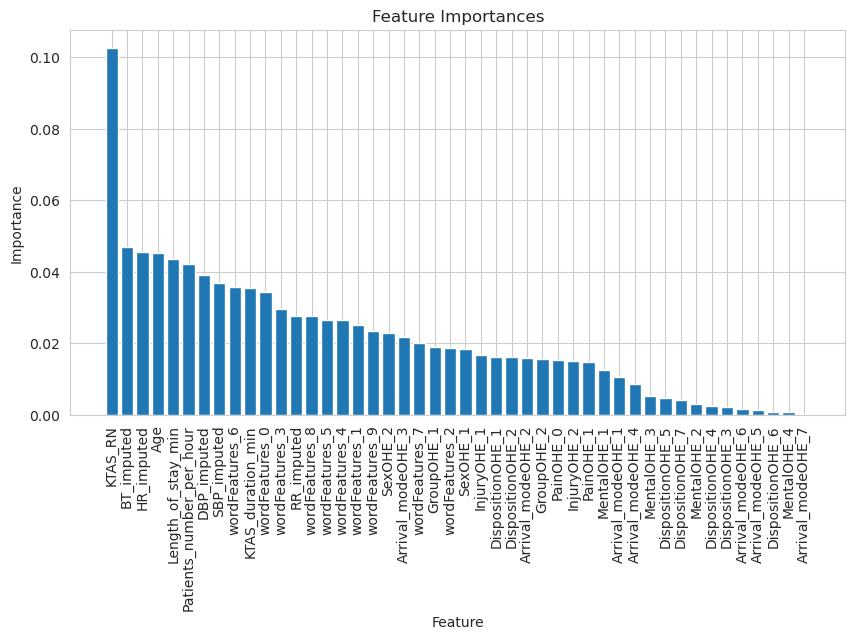

In [105]:
x_values = list(varlist["name"])

import matplotlib.pyplot as plt

plt.figure(figsize = (10, 5))
plt.bar(varlist["name"], varlist["score"], orientation = 'vertical')
plt.xticks(x_values, varlist["name"], rotation = 90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')
plt.show()

### Model 3: One-vs-Rest

1) Random Forest base classifier

In [142]:
predDF_ovr_rf.groupBy("prediction") \
      .count() \
      .sort("count", ascending = False) \
      .show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  218|
|       2.0|   17|
|       1.0|    1|
+----------+-----+



In [143]:
# Performance metrics (with hyperparameters tuning)
mcEvaluatorAcc = MulticlassClassificationEvaluator(metricName = "accuracy")
print(f"Accuracy: {mcEvaluatorAcc.evaluate(predDF_ovr_rf)}")
mcEvaluatorF1 = MulticlassClassificationEvaluator(metricName = "f1")
print(f"F1-Score: {mcEvaluatorF1.evaluate(predDF_ovr_rf)}")
mcEvaluatorWR = MulticlassClassificationEvaluator(metricName = "weightedRecall")
print(f"Weighted Recall: {mcEvaluatorWR.evaluate(predDF_ovr_rf)}")
mcEvaluatorWP = MulticlassClassificationEvaluator(metricName = "weightedPrecision")
print(f"Weighted Precision: {mcEvaluatorWP.evaluate(predDF_ovr_rf)}")

Accuracy: 0.8220338983050848
F1-Score: 0.7911895190496885
Weighted Recall: 0.8220338983050848
Weighted Precision: 0.7685315612794643


In [144]:
preds_and_labels = predDF_ovr_rf.select(['prediction','mistriage']).withColumn('label', F.col('mistriage').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[187.   1.  10.]
 [ 10.   0.   0.]
 [ 21.   0.   7.]]


2) Logistic regression base classifier

In [137]:
predDF_ovr_lr.groupBy("prediction") \
      .count() \
      .sort("count", ascending = False) \
      .show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   90|
|       1.0|   88|
|       2.0|   58|
+----------+-----+



In [138]:
# Performance metrics (with hyperparameters tuning)
mcEvaluatorAcc = MulticlassClassificationEvaluator(metricName = "accuracy")
print(f"Accuracy: {mcEvaluatorAcc.evaluate(predDF_ovr_lr)}")
mcEvaluatorF1 = MulticlassClassificationEvaluator(metricName = "f1")
print(f"F1-Score: {mcEvaluatorF1.evaluate(predDF_ovr_lr)}")
mcEvaluatorWR = MulticlassClassificationEvaluator(metricName = "weightedRecall")
print(f"Weighted Recall: {mcEvaluatorWR.evaluate(predDF_ovr_lr)}")
mcEvaluatorWP = MulticlassClassificationEvaluator(metricName = "weightedPrecision")
print(f"Weighted Precision: {mcEvaluatorWP.evaluate(predDF_ovr_lr)}")

Accuracy: 0.4110169491525424
F1-Score: 0.49433411027004415
Weighted Recall: 0.4110169491525424
Weighted Precision: 0.7508879708835875


In [139]:
preds_and_labels = predDF_ovr_lr.select(['prediction','mistriage']).withColumn('label', F.col('mistriage').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[77. 79. 42.]
 [ 4.  5.  1.]
 [ 9.  4. 15.]]
